# Message Polarity Prediction : Weekend Hackathon #3

Given are 53 distinguishing factors that can help in understanding the polarity(Good or Bad) of a message,  your objective as a data scientist is to build a Machine Learning model that can predict whether a text message has brought you good news or bad news.

You are provided with the normalized frequencies of 50 words/emojis (Freq_Of_Word_1 to Freq_Of_Word_50) along with 3 engineered features listed below:

* TotalEmojiCharacters: Total number of individual emoji characters normalized. (eg. 🙂 )
* LengthOFFirstParagraph: The total length of the first paragraph in words normalized
* StylizedLetters: Total number of letters or characters with a styling element normalized
* Target Variable: IsGoodNews

### Import Libraries

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
import time
%matplotlib inline
# Classification
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier

import xgboost as xgb
import lightgbm as lgb
import catboost as cat

# Preprocessing
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from mlxtend.classifier import StackingClassifier
from datetime import datetime, timedelta
from sklearn.naive_bayes import MultinomialNB

### Load Data

In [36]:
test = pd.read_csv('../input/machinehackmessagepolarity/Test.csv')
train = pd.read_csv('../input/machinehackmessagepolarity/Train.csv')

In [37]:
target = 'IsGoodNews'
org_feat = train.columns
train[target].value_counts(normalize=True)

0    0.611404
1    0.388596
Name: IsGoodNews, dtype: float64

In [38]:
df=train.append(test,ignore_index=True)

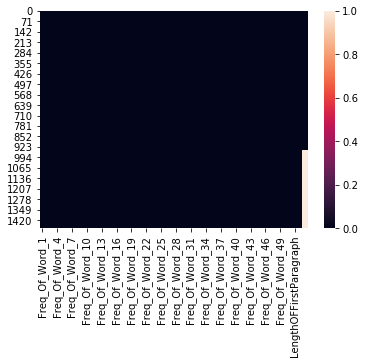

In [39]:
sns.heatmap(df.isnull())

In [40]:
# import pandas_profiling
# prof = pandas_profiling.ProfileReport(df)
# prof.to_file(output_file='output.html')

In [41]:
df.columns

Index(['Freq_Of_Word_1', 'Freq_Of_Word_2', 'Freq_Of_Word_3', 'Freq_Of_Word_4',
       'Freq_Of_Word_5', 'Freq_Of_Word_6', 'Freq_Of_Word_7', 'Freq_Of_Word_8',
       'Freq_Of_Word_9', 'Freq_Of_Word_10', 'Freq_Of_Word_11',
       'Freq_Of_Word_12', 'Freq_Of_Word_13', 'Freq_Of_Word_14',
       'Freq_Of_Word_15', 'Freq_Of_Word_16', 'Freq_Of_Word_17',
       'Freq_Of_Word_18', 'Freq_Of_Word_19', 'Freq_Of_Word_20',
       'Freq_Of_Word_21', 'Freq_Of_Word_22', 'Freq_Of_Word_23',
       'Freq_Of_Word_24', 'Freq_Of_Word_25', 'Freq_Of_Word_26',
       'Freq_Of_Word_27', 'Freq_Of_Word_28', 'Freq_Of_Word_29',
       'Freq_Of_Word_30', 'Freq_Of_Word_31', 'Freq_Of_Word_32',
       'Freq_Of_Word_33', 'Freq_Of_Word_34', 'Freq_Of_Word_35',
       'Freq_Of_Word_36', 'Freq_Of_Word_37', 'Freq_Of_Word_38',
       'Freq_Of_Word_39', 'Freq_Of_Word_40', 'Freq_Of_Word_41',
       'Freq_Of_Word_42', 'Freq_Of_Word_43', 'Freq_Of_Word_44',
       'Freq_Of_Word_45', 'Freq_Of_Word_46', 'Freq_Of_Word_47',
       'Fre

### Feature Engineering

In [42]:
def denormalise(col) :
    x1 = col 
    diff = np.diff(np.sort(col))
    x1_shift = x1/np.unique(diff)[1]
    x1_shift_1 = x1_shift - (np.sort(x1_shift)[1] - int(np.sort(x1_shift)[1]))
    x1_shift_fin = x1_shift_1 - np.sort(x1_shift_1)[1]
    
    return x1_shift_fin

In [43]:
def ispresent(col) :
    x1 = denormalise(col)
    x1 = ((x1>0)*1).astype(int)
    return x1

In [44]:
df.columns


Index(['Freq_Of_Word_1', 'Freq_Of_Word_2', 'Freq_Of_Word_3', 'Freq_Of_Word_4',
       'Freq_Of_Word_5', 'Freq_Of_Word_6', 'Freq_Of_Word_7', 'Freq_Of_Word_8',
       'Freq_Of_Word_9', 'Freq_Of_Word_10', 'Freq_Of_Word_11',
       'Freq_Of_Word_12', 'Freq_Of_Word_13', 'Freq_Of_Word_14',
       'Freq_Of_Word_15', 'Freq_Of_Word_16', 'Freq_Of_Word_17',
       'Freq_Of_Word_18', 'Freq_Of_Word_19', 'Freq_Of_Word_20',
       'Freq_Of_Word_21', 'Freq_Of_Word_22', 'Freq_Of_Word_23',
       'Freq_Of_Word_24', 'Freq_Of_Word_25', 'Freq_Of_Word_26',
       'Freq_Of_Word_27', 'Freq_Of_Word_28', 'Freq_Of_Word_29',
       'Freq_Of_Word_30', 'Freq_Of_Word_31', 'Freq_Of_Word_32',
       'Freq_Of_Word_33', 'Freq_Of_Word_34', 'Freq_Of_Word_35',
       'Freq_Of_Word_36', 'Freq_Of_Word_37', 'Freq_Of_Word_38',
       'Freq_Of_Word_39', 'Freq_Of_Word_40', 'Freq_Of_Word_41',
       'Freq_Of_Word_42', 'Freq_Of_Word_43', 'Freq_Of_Word_44',
       'Freq_Of_Word_45', 'Freq_Of_Word_46', 'Freq_Of_Word_47',
       'Fre

In [45]:
df['sum_of_words'] = 0
df['totsum_of_words'] = 0

In [46]:
for col in org_feat:
    if col not in ['IsGoodNews'] : 
        coln = col+'_denormalised'
        df[coln] = denormalise(df[col])
        colname = col+'_is_present'
        df[colname] = ispresent(df[col])
        df['sum_of_words'] += df[colname]
        df['totsum_of_words'] += df[coln]
df = df.drop(columns = ['Freq_Of_Word_1', 'Freq_Of_Word_2', 'Freq_Of_Word_3', 'Freq_Of_Word_4',
       'Freq_Of_Word_5', 'Freq_Of_Word_6', 'Freq_Of_Word_7', 'Freq_Of_Word_8',
       'Freq_Of_Word_9', 'Freq_Of_Word_10', 'Freq_Of_Word_11',
       'Freq_Of_Word_12', 'Freq_Of_Word_13', 'Freq_Of_Word_14',
       'Freq_Of_Word_15', 'Freq_Of_Word_16', 'Freq_Of_Word_17',
       'Freq_Of_Word_18', 'Freq_Of_Word_19', 'Freq_Of_Word_20',
       'Freq_Of_Word_21', 'Freq_Of_Word_22', 'Freq_Of_Word_23',
       'Freq_Of_Word_24', 'Freq_Of_Word_25', 'Freq_Of_Word_26',
       'Freq_Of_Word_27', 'Freq_Of_Word_28', 'Freq_Of_Word_29',
       'Freq_Of_Word_30', 'Freq_Of_Word_31', 'Freq_Of_Word_32',
       'Freq_Of_Word_33', 'Freq_Of_Word_34', 'Freq_Of_Word_35',
       'Freq_Of_Word_36', 'Freq_Of_Word_37', 'Freq_Of_Word_38',
       'Freq_Of_Word_39', 'Freq_Of_Word_40', 'Freq_Of_Word_41',
       'Freq_Of_Word_42', 'Freq_Of_Word_43', 'Freq_Of_Word_44',
       'Freq_Of_Word_45', 'Freq_Of_Word_46', 'Freq_Of_Word_47',
       'Freq_Of_Word_48', 'Freq_Of_Word_49', 'Freq_Of_Word_50',], axis=1)
df['mean_of_words'] = df['totsum_of_words']/df['sum_of_words']

In [47]:
df.shape

(1474, 113)

In [48]:
imp_words = ['Freq_Of_Word_24_denormalised', 'Freq_Of_Word_7_denormalised',
       'Freq_Of_Word_27_denormalised', 'Freq_Of_Word_25_denormalised',
       'Freq_Of_Word_46_denormalised', 'Freq_Of_Word_48_denormalised',
       'Freq_Of_Word_23_denormalised', 'Freq_Of_Word_16_denormalised',
       'Freq_Of_Word_21_denormalised', 'Freq_Of_Word_29_denormalised',
       'Freq_Of_Word_8_denormalised', 'Freq_Of_Word_20_denormalised',
       'Freq_Of_Word_2_denormalised', 'Freq_Of_Word_28_denormalised',
       'Freq_Of_Word_33_denormalised', 'Freq_Of_Word_13_denormalised',
         'Freq_Of_Word_45_denormalised',
       'Freq_Of_Word_10_denormalised', 'Freq_Of_Word_49_denormalised',
       'Freq_Of_Word_42_denormalised', 
       'Freq_Of_Word_17_denormalised', 'Freq_Of_Word_5_denormalised',
       'Freq_Of_Word_19_denormalised',  'Freq_Of_Word_18_denormalised',
       'Freq_Of_Word_50_denormalised', 'Freq_Of_Word_37_denormalised',
       'Freq_Of_Word_12_denormalised', 'Freq_Of_Word_11_denormalised']

In [49]:
df.columns

Index(['TotalEmojiCharacters', 'LengthOFFirstParagraph', 'StylizedLetters',
       'IsGoodNews', 'sum_of_words', 'totsum_of_words',
       'Freq_Of_Word_1_denormalised', 'Freq_Of_Word_1_is_present',
       'Freq_Of_Word_2_denormalised', 'Freq_Of_Word_2_is_present',
       ...
       'Freq_Of_Word_49_is_present', 'Freq_Of_Word_50_denormalised',
       'Freq_Of_Word_50_is_present', 'TotalEmojiCharacters_denormalised',
       'TotalEmojiCharacters_is_present',
       'LengthOFFirstParagraph_denormalised',
       'LengthOFFirstParagraph_is_present', 'StylizedLetters_denormalised',
       'StylizedLetters_is_present', 'mean_of_words'],
      dtype='object', length=113)

In [32]:
#  for i in range(1,51):
#     colname = 'Freq_Of_Word_'+str(i)+'_denormalised'
#     agg_func = {
#         colname: ['mean']    
#     }
#     agg_func = df.groupby(['sum_of_words']).agg(agg_func)
#     agg_func.columns = [ 'Sumofwords_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
#     agg_func.reset_index(inplace=True)
#     df = df.merge(agg_func, on=['sum_of_words'], how='left')
#     df[colname+'_is_present_emoji'] = df[colname] * df['TotalEmojiCharacters_is_present']
#     df[colname+'_is_present_stylised'] = df[colname] * df['StylizedLetters_is_present']

In [33]:
feat = df.columns
feat = feat.drop(target)
org_feat = org_feat.drop(target)

KeyError: "['IsGoodNews'] not found in axis"

In [34]:

df_train=df[df[target].isnull()==False].copy()
df_test=df[df[target].isnull()==True].copy()
df_test.drop(columns=[target],axis=1, inplace=True)

print(df_train.shape,df_test.shape)

(947, 263) (527, 262)


In [50]:
x = df_train.drop(target,axis=1)
y = df_train[target]

In [51]:
x.columns

Index(['TotalEmojiCharacters', 'LengthOFFirstParagraph', 'StylizedLetters',
       'sum_of_words', 'totsum_of_words', 'Freq_Of_Word_1_denormalised',
       'Freq_Of_Word_1_is_present', 'Freq_Of_Word_2_denormalised',
       'Freq_Of_Word_2_is_present', 'Freq_Of_Word_3_denormalised',
       ...
       'Freq_Of_Word_47_denormalised_is_present_stylised',
       'Sumofwords_Freq_Of_Word_48_denormalised_mean',
       'Freq_Of_Word_48_denormalised_is_present_emoji',
       'Freq_Of_Word_48_denormalised_is_present_stylised',
       'Sumofwords_Freq_Of_Word_49_denormalised_mean',
       'Freq_Of_Word_49_denormalised_is_present_emoji',
       'Freq_Of_Word_49_denormalised_is_present_stylised',
       'Sumofwords_Freq_Of_Word_50_denormalised_mean',
       'Freq_Of_Word_50_denormalised_is_present_emoji',
       'Freq_Of_Word_50_denormalised_is_present_stylised'],
      dtype='object', length=262)

### Feature Selection

In [52]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [53]:
X_train.shape

(757, 262)

In [54]:
#model = lgb.LGBMClassifier()
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = f1_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = np.sort(model.feature_importances_)
dfth = pd.DataFrame({'Features':X_train.columns, 'Importance':model.feature_importances_}).sort_values(by='Importance',ascending=False)

acc = 0 
n_feat = 0 
opt_th = 0

for thresh in list(set(thresholds)) :
    dfth1 = dfth[dfth['Importance']>=thresh]
    X_train1 = X_train[dfth1.Features]
    X_test1 = X_test[dfth1.Features]
    model.fit(X_train1, y_train)
    y_pred = model.predict(X_test1)
    predictions = [round(value) for value in y_pred]
    accuracy = f1_score(y_test, predictions)
    #print(f"For threshold {thresh} and no of feat {len(dfth1.Features)} acc : {accuracy}")
    if accuracy>acc :
        acc = accuracy 
        n_feat = len(dfth1.Features)
        opt_th = thresh
        

print(f"highest acc : {acc} at {n_feat} features and threshhold {opt_th}")
    
#for thresh in thresholds:
    
    

Accuracy: 90.91%
highest acc : 0.9101796407185628 at 67 features and threshhold 0.0019925376400351524


In [55]:
dfth.head(20)

,Features,Importance
173,Freq_Of_Word_21_denormalised_is_present_emoji,0.152319
51,Freq_Of_Word_24_denormalised,0.102781
158,Freq_Of_Word_16_denormalised_is_present_emoji,0.093939
17,Freq_Of_Word_7_denormalised,0.091658
53,Freq_Of_Word_25_denormalised,0.047374
57,Freq_Of_Word_27_denormalised,0.041197
248,Freq_Of_Word_46_denormalised_is_present_emoji,0.038124
174,Freq_Of_Word_21_denormalised_is_present_stylised,0.027931
15,Freq_Of_Word_6_denormalised,0.019135
95,Freq_Of_Word_46_denormalised,0.018416


In [56]:

dfth1 = dfth[dfth['Importance']>=opt_th]
X_train1 = X_train[dfth1.Features]
opt_feat = X_train1.columns
len(opt_feat)

67

In [57]:
opt_feat

Index(['Freq_Of_Word_21_denormalised_is_present_emoji',
       'Freq_Of_Word_24_denormalised',
       'Freq_Of_Word_16_denormalised_is_present_emoji',
       'Freq_Of_Word_7_denormalised', 'Freq_Of_Word_25_denormalised',
       'Freq_Of_Word_27_denormalised',
       'Freq_Of_Word_46_denormalised_is_present_emoji',
       'Freq_Of_Word_21_denormalised_is_present_stylised',
       'Freq_Of_Word_6_denormalised', 'Freq_Of_Word_46_denormalised',
       'Freq_Of_Word_23_denormalised',
       'Sumofwords_Freq_Of_Word_50_denormalised_mean',
       'Freq_Of_Word_28_denormalised', 'Freq_Of_Word_16_denormalised',
       'Freq_Of_Word_49_denormalised',
       'Freq_Of_Word_5_denormalised_is_present_emoji',
       'Freq_Of_Word_9_denormalised_is_present_emoji', 'TotalEmojiCharacters',
       'Freq_Of_Word_29_denormalised',
       'Freq_Of_Word_6_denormalised_is_present_emoji',
       'Sumofwords_Freq_Of_Word_6_denormalised_mean',
       'Freq_Of_Word_33_denormalised',
       'Sumofwords_Freq_Of_Wor

### Modelling

In [58]:
def baseliner(X, y, cv=3, metric='f1_macro'):
    print("Baseliner Models\n")
    eval_dict = {}
    models = [lgb.LGBMClassifier(), xgb.XGBClassifier(),
              #GradientBoostingClassifier(),
                  LogisticRegression(), GaussianNB(), RandomForestClassifier(), DecisionTreeClassifier(),
                  ExtraTreeClassifier(), AdaBoostClassifier(), BaggingClassifier(),
              ExtraTreesClassifier(),
              SVC(probability=True), KNeighborsClassifier(),
              MultinomialNB()
                 ]
    print("Model Name \t |   f1")
    print("--" * 50)

    for index, model in enumerate(models, 0):
        model_name = str(model).split("(")[0]
        eval_dict[model_name] = {}

        results = cross_val_score(model, X, y, cv=cv, scoring=metric)
        eval_dict[model_name]['cv'] = results.mean()

        print("%s \t | %.4f \t" % (
            model_name[:12], eval_dict[model_name]['cv']))

In [59]:
baseliner(df_train[opt_feat],df_train[target])

Baseliner Models

Model Name 	 |   f1
----------------------------------------------------------------------------------------------------
LGBMClassifi 	 | 0.9028 	
XGBClassifie 	 | 0.9114 	
LogisticRegr 	 | 0.8812 	


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


GaussianNB 	 | 0.8614 	
RandomForest 	 | 0.9013 	
DecisionTree 	 | 0.8630 	
ExtraTreeCla 	 | 0.7873 	
AdaBoostClas 	 | 0.8911 	
BaggingClass 	 | 0.8973 	
ExtraTreesCl 	 | 0.9016 	
SVC 	 | 0.8498 	
KNeighborsCl 	 | 0.8080 	
MultinomialN 	 | nan 	


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Negative values in data passed to MultinomialNB (input X)

  FitFailedWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Negative values in data passed to MultinomialNB (input X)

  FitFailedWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Negative values in data passed to MultinomialNB (input X)

  FitFailedWarning)


In [60]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True


In [ ]:
def lgb_tune(train, teset, features, target, plot=True):
    
    x = train[features]
    y = train[target]
    
    print("Parameter Tuning :")

    param_grid = {
    'num_leaves':[20,30],
    'max_depth':[-1],
    'subsample':[0.8,0.9,1],
    'colsample_bytree': [0.3,0.6,0.8],
    'min_child_samples': [20,10,30],
    'min_split_gain':[1],
    'subsample' : [0.7],
    'reg_alpha' : [0.6,0.7],
    'reg_lambda' : [0.6,0.7,0.8],
    'device': ['gpu']
    } 

    model = lgb.LGBMClassifier(
        objective='binary',
        boosting_type='gbdt', 
        learning_rate=0.01, 
        n_estimators=1000, 
        silent=False
    )
    
    skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 1001)
    
    lgb_grid = GridSearchCV(model, param_grid, cv=skf.split(x,y), scoring='f1', verbose=1, n_jobs=4)
    lgb_grid.fit(x, y)

    print(lgb_grid.best_params_)
    print(lgb_grid.best_score_)

    #predictions = lgb_grid.predict(test[features]) 
    
    return lgb_grid.best_estimator_, #predictions, lgb_grid.best_params_

In [ ]:
df_test[opt_feat].columns

In [ ]:
lgbM = lgb_tune(df_train, df_test,opt_feat, target, True)


In [ ]:
lgbM 
lgbM= lgbM[0]

In [ ]:
X = df_train[opt_feat]
y = df_train[target]
err=[]
y_pred_tot=[]
from sklearn.model_selection import KFold,StratifiedKFold

fold=StratifiedKFold(n_splits=10,shuffle=True,random_state=1996)

i=1

for train_index, test_index in fold.split(X,y):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m=lgbM
    m.fit(X_train,y_train,eval_set=[(X_test, y_test)], early_stopping_rounds=200,verbose=100)
    preds=m.predict_proba(X_test)[:,-1]
    print("err: ",f1_score(y_test,preds.round()))
    err.append(f1_score(y_test,preds.round()))
    p = m.predict_proba(df_test[opt_feat])[:,-1]
    i=i+1
    y_pred_tot.append(p)

In [ ]:
preds = lgbM[0].predict(df_test[opt_feat])

In [ ]:
preds_df = pd.DataFrame()
preds_df[target] = ((preds > 0.5) * 1).astype('int')

In [ ]:
times = time.strftime("%m-%d-")+'{:%H_%M_%S}'.format(datetime.now() + timedelta(hours=5.5))
preds_df.to_excel('submission-lgb_'+times+'.xlsx', index=False)
preds_df.head(10)


### XGB

In [ ]:
def xgb_tune(train, test, features, target):
    
    x = train[features]
    y = train[target]
    
    print("Parameter Tuning :")

    param_grid = {
    'max_depth':[3,4,6], ##
    'subsample':[0.8],
    'colsample_bytree': [1],
    'min_child_weight': [0.4, 0.5],
    'gamma': [0.5],
    'reg_lambda': [1, 1.5],
    } 

    model = xgb.XGBClassifier(
        objective='binary:logistic',
        learning_rate=0.01, 
        n_estimators=2000, 
        tree_method = "gpu_hist",
        silent=False
    )

    skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 1001)

    xgb_grid = GridSearchCV(model, param_grid, cv=skf.split(x,y), scoring='f1', verbose=1, n_jobs=4)
   
    xgb_grid.fit(x, y)

    print(xgb_grid.best_params_)
    print(xgb_grid.best_score_)

    predictions = xgb_grid.predict(test[features]) 


    return predictions, xgb_grid.best_estimator_, xgb_grid.best_params_,xgb_grid.best_score_

In [ ]:
pred, xgbM, best_params, score = xgb_tune(df_train, df_test, opt_feat, target)

In [ ]:
X = df_train[opt_feat]
y = df_train[target]
err=[]
y_pred_tot=[]
from sklearn.model_selection import KFold,StratifiedKFold

fold=StratifiedKFold(n_splits=10,shuffle=True,random_state=1994)

i=1

for train_index, test_index in fold.split(X,y):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m=xgbM
    m.fit(X_train,y_train, early_stopping_rounds=100, eval_set=[(X_test, y_test)], verbose=10)
          
    preds=m.predict_proba(X_test)[:,-1]
    print("err: ",f1_score(y_test,preds.round()))
    err.append(f1_score(y_test,preds.round()))
    p = m.predict_proba(df_test[opt_feat])[:,-1]
    i=i+1
    y_pred_tot.append(p)

In [ ]:
y_pred_xgb = np.mean(y_pred_tot, 0)

In [ ]:
y_pred_lgb = np.mean(y_pred_tot, 0)

In [ ]:
y_pred = y_pred_xgb*0.7 + y_pred_lgb*0.3

In [ ]:
preds_df = pd.DataFrame()
preds_df[target] = ((y_pred > 0.5) * 1).astype('int')

In [ ]:
times = time.strftime("%m-%d-")+'{:%H_%M_%S}'.format(datetime.now() + timedelta(hours=5.5))
preds_df.to_excel('submission-xglgb_'+times+'.xlsx', index=False)
preds_df.head(10)

### Stacking

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_train[opt_feat], df_train[target], test_size=0.20, random_state=43)

In [ ]:
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999

for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[ lgbM, xgbM], meta_classifier=lr, use_probas=True)
    sclf.fit(X_train, y_train)
    y_pred = sclf.predict(X_test)
    preds_df = pd.DataFrame()
    preds_df[target] = ((y_pred > 0.3) * 1).astype('int')
    predictions = preds_df[target]
    print(f"Log Lossfor alpha {i} : { (f1_score(y_test, predictions))}")
    
#     f1_best =(f1_score(y_test, predictions))
#     if best_alpha > log_error:
#         best_alpha = log_error



In [ ]:
lr = LogisticRegression(C=0.01)
sclf = StackingClassifier(classifiers=[lgbM, xgbM], meta_classifier=lr, use_probas=True)

In [ ]:
X = df_train[opt_feat]
y = df_train[target]
err=[]
y_pred_tot=[]
from sklearn.model_selection import KFold,StratifiedKFold

fold=StratifiedKFold(n_splits=10,shuffle=True,random_state=1994)

i=1

for train_index, test_index in fold.split(X,y):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m=sclf
    m.fit(X_train,y_train)
    preds=m.predict_proba(X_test)[:,-1]
    print(f"fold {i} :")
    print("err: ",f1_score(y_test,preds.round()))
    err.append(f1_score(y_test,preds.round()))
    p = m.predict_proba(df_test[opt_feat])[:,-1]
    i=i+1
    y_pred_tot.append(p)

In [ ]:
y_pred_sclf = np.mean(y_pred_tot, 0)

In [ ]:
predictions_st = sclf.predict(df_test[opt_feat]) 

In [ ]:
preds_df = pd.DataFrame()
preds_df[target] = ((y_pred_sclf > 0.5) * 1).astype('int')

In [ ]:
times = time.strftime("%m-%d-")+'{:%H_%M_%S}'.format(datetime.now() + timedelta(hours=5.5))
preds_df.to_excel('submission-xgb_lgb_stacking_'+times+'.xlsx', index=False)
preds_df.head(10)